In [1]:
import lorm
from nfft import nfft
import disc.energy_curveling_2d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
img = 256-plt.imread('data/eyeofthetiger.jpg')
img_N_half = int(img.shape[0]/2)

M = 2*img_N_half
x = np.linspace(-0.5,0.5,M,endpoint=False)
x1,x2 = np.meshgrid(x,x)
quat_nodes = np.array([x1.ravel()[:],-x2.ravel()[:]]).transpose()
mu = img[:]
#plt.imshow(256-mu.reshape(M,M))

nfft2d = nfft.NFFT2D(M**2,2*img_N_half,2*img_N_half)
nfft2d.x = quat_nodes
nfft2d.precompute_x()
nfft2d.f = mu/M**2
nfft2d.adjoint()
mu_hat = np.zeros([2*img_N_half,2*img_N_half],dtype=np.complex)
mu_hat[:] = nfft2d.f_hat/nfft2d.f_hat[img_N_half,img_N_half]

In [120]:
e2 = lorm.manif.EuclideanSpace(2)
points = lorm.manif.ManifoldPointArray(e2)
m = 96
t = np.linspace(0,2*np.pi,m,endpoint=False)
points.coords = np.zeros([m,2])
points.coords[:,1] = 0.2*np.cos(t)
points.coords[:,0] = 0.2*np.sin(t)
points_new = lorm.manif.ManifoldPointArray(e2)
L = 0.97*np.sqrt(2)*4

In [123]:
for k in range(2*6):
    N_half = 4*np.int(L/0.97)
    N=2*N_half
    m = points.coords.shape[0]
    energy = disc.energy_curveling_2d.plan(m,N,0.5,L)
    if img_N_half >= N_half:
        energy._mu_hat[:] = mu_hat[img_N_half-N_half:img_N_half+N_half,img_N_half-N_half:img_N_half+N_half]
    else:
        energy._mu_hat[N_half-img_N_half:N_half+img_N_half,N_half-img_N_half:N_half+img_N_half] = mu_hat[:]
    points_new.coords = np.zeros([m,2])

    print(N,m,energy._equality_constraint)
    
    energy._alpha = 100/energy._L**5
    method= lorm.optim.ConjugateGradientMethod(max_iter=100,tol_grad=1e-12)
    points_new.coords[:] = points.coords[:]
    points_new = method.run(energy,points_new)
    
    np.savetxt("tiger_{}.txt".format(i),points_new.coords)
    
    tempc = points_new.coords
    m2 = len(tempc)
    temp = np.zeros([2*m2,2])
    for i in range(m2):
        temp[2*i,:] = tempc[i,:]
    for i in range(m2-1):
        temp[2*i+1,:] = (tempc[i,:]+tempc[i+1,:])/2
    temp[2*m2-1,:] = (tempc[0,:]+tempc[m2-1,:])/2

    points.coords = temp  
    
    L*=np.sqrt(2)

88 384 False
Initial value: f[0] = 0.004920895005348924
f[1] = 0.0034380859070385094
f[2] = 0.0032909583889895134
f[3] = 0.0029759279512745216
f[4] = 0.0028864904970622475
f[5] = 0.0027342956522122043
f[6] = 0.002607706412686532
f[7] = 0.00252540906150853
f[8] = 0.002447306394235294
f[9] = 0.0023858556607373738
f[10] = 0.0023293620617803727
f[11] = 0.002275838945791952
f[12] = 0.002238790982036871
f[13] = 0.002211201575031224
f[14] = 0.0021906315517521697
f[15] = 0.002171777391335455
f[16] = 0.002152763376222496
f[17] = 0.002137121833516004
f[18] = 0.0021213400121346654
f[19] = 0.0021083859599851673
f[20] = 0.0020973386180673124
f[21] = 0.0020873536567456667
f[22] = 0.0020772388390254103
f[23] = 0.002067029709433272
f[24] = 0.0020571364185732756
f[25] = 0.0020492632408524356
f[26] = 0.00204335321107765
f[27] = 0.002039071838252543
f[28] = 0.0020355217428250218
f[29] = 0.002032187518604729
f[30] = 0.0020285993447736925
f[31] = 0.002024613438822746
f[32] = 0.002020969940744338
f[33] = 0.

<IPython.core.display.Javascript object>


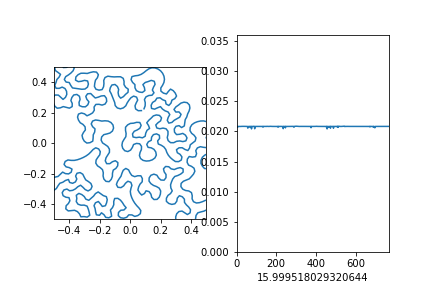

In [125]:
%matplotlib notebook
fig = plt.figure()

ax = fig.add_subplot(121)
#ax.axis(np.array([-0.28,-0.26,0.26,0.28]))
#ax.axis(np.array([0.21,0.24,-0.44,-0.42]))
ax.axis(np.array([-0.5,0.5,-0.5,0.5]))
ax.axes.set_aspect(1)
line = plt.Line2D(points_new.coords[:,0],points_new.coords[:,1])#,marker='*',markersize=2)
ax.add_line(line)
bx = fig.add_subplot(122)
#bx.axis(np.array([900,950,0.0045,0.0015]))
bx.axis(np.array([0,m,0.000,1/np.sqrt(m)]))
bx.set_xlabel(np.sum(energy._eval_lengths(points_new.coords)))
distance = plt.Line2D(np.linspace(0,m,m),energy._eval_lengths(points_new.coords))
bx.add_line(distance)
def update_points(p):
    line.set_xdata(p.coords[:,0])
    line.set_ydata(p.coords[:,1])
    distance.set_ydata(energy._eval_lengths(p.coords))
    bx.set_xlabel(np.sum(energy._eval_lengths(p.coords)))
    fig.canvas.draw()
    return


In [126]:
#energy._alpha =.00000010
energy._L =np.sqrt(m/3)#15#3.030#
energy._alpha = 10000/energy._L**5#2**(-5/2*9)/10
method= lorm.optim.ConjugateGradientMethod(max_iter=50,tol_grad=1e-12)
method.listener = update_points
#points_new.coords[:] = points.coords[:]
for i in range(1):
    points_new = method.run(energy,points_new)

Initial value: f[0] = 0.0012303393813939715
f[1] = 0.001007105771336668
f[2] = 0.0008788518421295492
f[3] = 0.0007954307674782983
f[4] = 0.0007465302136632616
f[5] = 0.0007140073633778733
f[6] = 0.0007040471567955045
f[7] = 0.0007005716374809319
f[8] = 0.0006988250641488219
f[9] = 0.000697962067147802
f[10] = 0.0006972309533233947
f[11] = 0.0006968642014674931
f[12] = 0.0006964305764953175
f[13] = 0.0006959364913156656
f[14] = 0.000695221321955947
f[15] = 0.0006944759532125886
f[16] = 0.0006937952884593747
f[17] = 0.0006932438139905774
f[18] = 0.0006926269781578135
f[19] = 0.000692130786748099
f[20] = 0.0006916474557270211
f[21] = 0.0006911695317131581
f[22] = 0.0006906778880411057
f[23] = 0.0006902343719994098
f[24] = 0.0006898847261796636
f[25] = 0.0006895679185582189
f[26] = 0.0006892033393117659
f[27] = 0.0006888475077988937
f[28] = 0.0006885183723268545
f[29] = 0.0006882254711318213
f[30] = 0.000688007051938085
f[31] = 0.0006878110889842941
f[32] = 0.0006876437828721687
f[33] = 0.

In [68]:
np.sum((m*energy._eval_lengths(points_new.coords)-energy._L)<0)

93

In [107]:
np.sum(energy._eval_lengths(points_new.coords))

31.98708263237529

In [117]:
"tiger_{}.txt".format(1)

'tiger_1.txt'

In [129]:
#points_new.coords = temp
tempc = points_new.coords
m2 = len(tempc)
temp = np.zeros([2*m2,2])
for i in range(m2):
    temp[2*i,:] = tempc[i,:]
for i in range(m2-1):
    temp[2*i+1,:] = (tempc[i,:]+tempc[i+1,:])/2
temp[2*m2-1,:] = (tempc[0,:]+tempc[m2-1,:])/2

m = len(temp)
points.coords = temp